In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import matthews_corrcoef , confusion_matrix , accuracy_score , precision_score , recall_score

In [2]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis, ProtParamData
import statistics as st
# function to get the features

def get_scale_features (seq, scale ,window, output_type): 
        
    ''' This function returns the features (max score and average score) of a chosen scale for a specific sequence. You can use a personalized 
    dictionary of scores or a one inside ProtParamData. You can check all the ProtParamData scales using the command dir(ProtParamData) A legend of each 
    param argument is given at the beginning of this file'''

    sequence = ProteinAnalysis(seq) 
    if type(scale)==dict:   
        scale_result = sequence.protein_scale(scale, window, edge=1)
        if len(seq)<window:
            scale_result = sequence.protein_scale(scale, len(seq), edge=1)
    else:

        param_dict = getattr(ProtParamData, scale)
        scale_result = sequence.protein_scale(param_dict, window, edge=1)
        if len(seq)<window:
            scale_result = sequence.protein_scale(param_dict, len(seq), edge=1)
    max_value=max(scale_result)
    mean_value=st.mean(scale_result)
    if output_type == "mean" :
        return mean_value
    else:
        return max_value

 # Von Heijine PERFORMANCE

In [3]:
#!pip install importnb
import sys
from importnb import Notebook

# add the folder vonheijine that contains our vonheijine functions
sys.path.append("../vonHeijne/")

# import the notebook that contains the pswm creator and the testing of vonheijine
with Notebook():
    import create_pswm, validation_and_testing_vonheijne


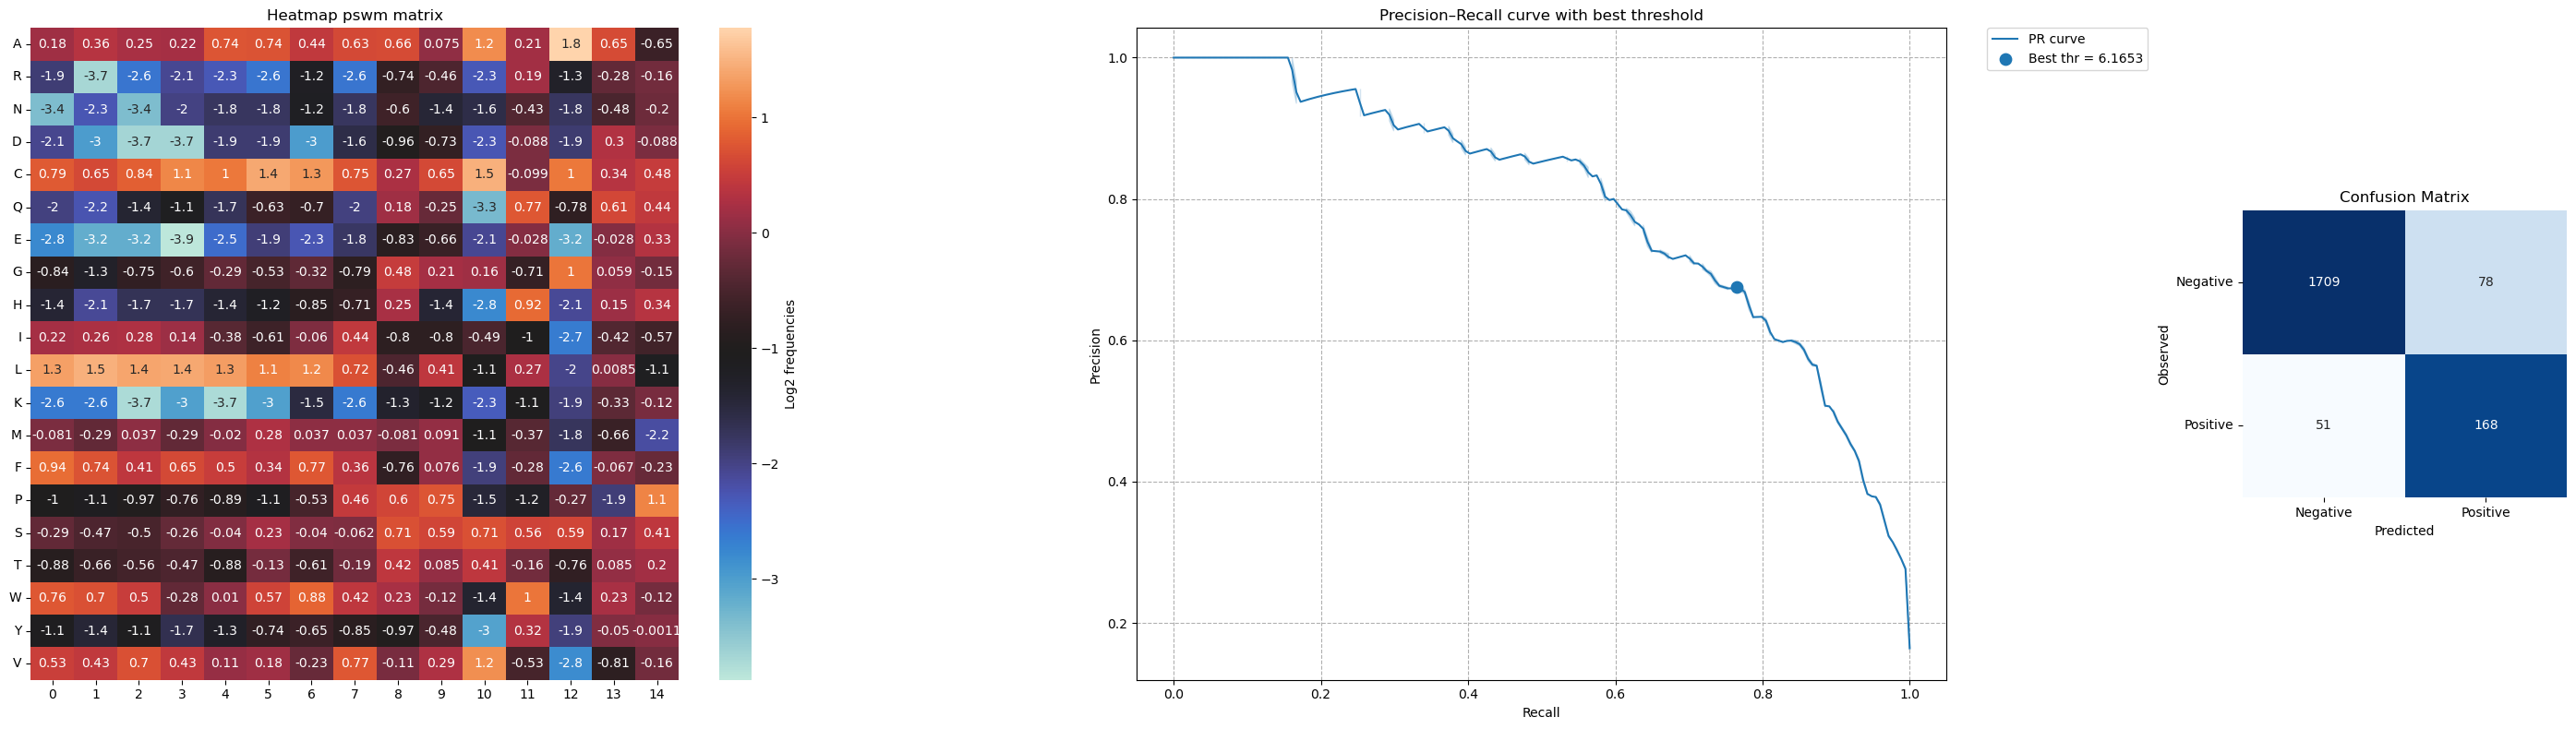

In [4]:
dataset = pd.read_csv("../Data_Preparation/train_bench.tsv", sep = "\t")
pswm=create_pswm.get_pswm(dataset.query("(Set=='1' or Set=='5' or Set=='3' or Set=='4') and Class=='Positive'"), 13,2)
stats=validation_and_testing_vonheijne.metrics(pswm, dataset.query("(Set=='2')") , dataset.query("Set=='Benchmark'"))

In [5]:
metrics_name = ["MCC", "Precision", "Accuracy", "Sensitivity" , "Confusion Matrix"]
for name, stat in zip(metrics_name,stats): 
    if name=="Confusion Matrix":
        confusion_df = pd.DataFrame(stat, columns=["Negative" , "Positive"], index=["Negative", "Positive"])
        print(f"{name} : \n{confusion_df}")
    else:    
        print(f"{name} = {stat}")

MCC = 0.6878342596948499
Precision = 0.9356929212362911
Accuracy = 0.6829268292682927
Sensitivity = 0.7671232876712328
Confusion Matrix : 
          Negative  Positive
Negative      1709        78
Positive        51       168


# SVM PERFORMANCE

ANALISI FN  
--> grafico a torta della taxonomy dei fn, fp, totale (dovremmo vedere che nelle piante abbiamo tante fp per la presenza del transit peptide)   
--> analizzare aa frequency distribution fn contro tp (histogram plot)  
--> analizzare composizione dei signal peptide dei tp contro la composizione del signal peptide dei fn  
--> lenght distribution dei signal peptide dei tp contro fn FATTO  
--> hydrophobicity distribution tp contro fn  FATTO  
--> in generale fare distribuzioni per tutte le features più informative  
ANALISI FP  
--> calcolare fpr sulle transmembrane domain proteins   
--> calcolare fpr sulle transmembrane domain proteins anche sul vonheijne  
--> tenere grafico percenturale transmembrane domain proteins e magari scriverci l'fpr  

In [6]:
#create the pipeline
pipeline = Pipeline([("scaler" , StandardScaler()) , ("svm" , SVC(cache_size=1500))])
# load training
loaded_data_train = np.load('training_features.npz')
x_train = loaded_data_train['matrix']
y_train = loaded_data_train['target']

# load testing
loaded_data_test = np.load('benchmark_features.npz')
x_test = loaded_data_test['matrix']
y_test = loaded_data_test['target']

#set the optimal parameters and train the model on train data
final_classifier = pipeline.set_params(svm__C=2.687775805186727, svm__gamma=0.012249546394282136  ,svm__kernel="rbf").fit(x_train, y_train)
#predict the benchmark set
bench_pred = final_classifier.predict(x_test)

In [7]:
svm_fp = []
svm_fn = []
#create lists of indexes of the false positive and false negative proteins
for i in range(len(y_test)):
    if bench_pred[i] == 0 and y_test[i] == 1:
        svm_fn.append(i)
    elif bench_pred[i] == 1 and y_test[i] == 0:
        svm_fp.append(i)
    else:
        pass

SVM Metrics:
MCC = 0.799246793566195 
Precision = 0.8034934497816594 
Sensitivity = 0.8401826484018264 
Accuracy = 0.9601196410767697


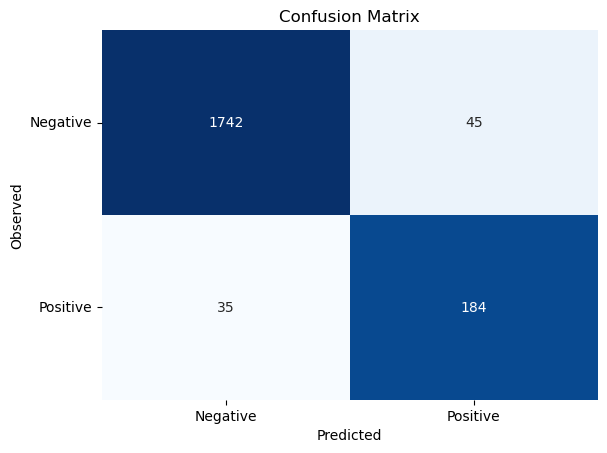

In [8]:
conf_mat = confusion_matrix( y_test, bench_pred)
svm_mcc = matthews_corrcoef(y_test , bench_pred)
svm_precision = precision_score(y_test , bench_pred)
svm_sensitivity = recall_score(y_test , bench_pred)
svm_accuracy = accuracy_score(y_test , bench_pred)
print(f"SVM Metrics:\nMCC = {svm_mcc} \nPrecision = {svm_precision} \nSensitivity = {svm_sensitivity} \nAccuracy = {svm_accuracy}")
sns.heatmap(
        conf_mat,
        annot=True,
        cmap="Blues",
        fmt="d",
        cbar=False,
        vmax = 200      
    )
plt.xlabel("Predicted")
plt.ylabel("Observed")  
plt.title("Confusion Matrix")  
plt.xticks(ticks=[0.5, 1.5], labels=["Negative", "Positive"])
plt.yticks(ticks=[0.5, 1.5], labels=["Negative", "Positive"], rotation=0)
plt.show()

In [9]:
# now import the dataset and create dataframes that only contain data of interest
benchmark=dataset.query("Set=='Benchmark'")
false_positives_df = benchmark.iloc[svm_fp]
false_negatives_df = benchmark.iloc[svm_fn]
true_positives_df = benchmark.query("Class == 'Positive'")
true_negatives_df = benchmark.query("Class == 'Negative'")
# create a new column in the benchmark dataframe to store information about classification
rows = benchmark.shape[0]
classification_col = []
for i in range(rows):
    if i in svm_fp:
        classification_col.append("FP")
        continue
    elif i in svm_fn:
        classification_col.append("FN")
        continue
    elif benchmark.iloc[i]["Class"] == "Negative":
        classification_col.append("TN")
    elif benchmark.iloc[i]["Class"] == "Positive":
        classification_col.append("TP")
benchmark["Prediction"]=classification_col

/tmp/ipykernel_4186/3743291469.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benchmark["Prediction"]=classification_col


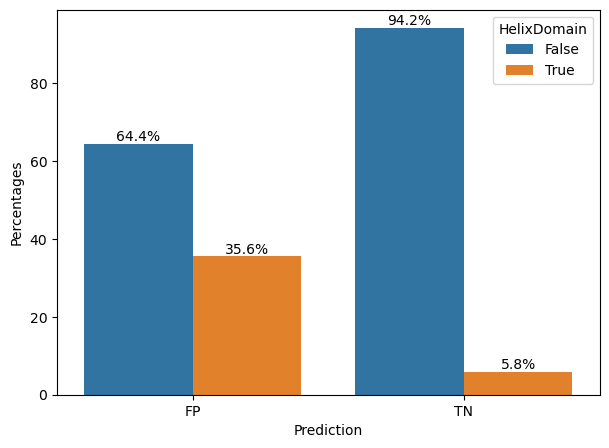

In [10]:
# make counts in function of prediction and helix domain presence
counts = (
    benchmark
    .groupby(["Prediction", "HelixDomain"])
    .size()
    .rename("n")
    .reset_index()
)

# compute percentage within each prediction group relative to its own size
counts["percent"] = counts.groupby("Prediction")["n"].transform(lambda s: ( s / s.sum())*100)

# plot the histogram
plt.figure(figsize=(7,5))
ax = sns.barplot(data=counts, x="Prediction", y="percent", hue="HelixDomain")
ax.set_ylabel("Percentages")
ax.set_xlabel("Prediction")
ax.legend(title="HelixDomain")
for c in ax.containers:
    ax.bar_label(c, fmt="%.1f%%")
plt.show()


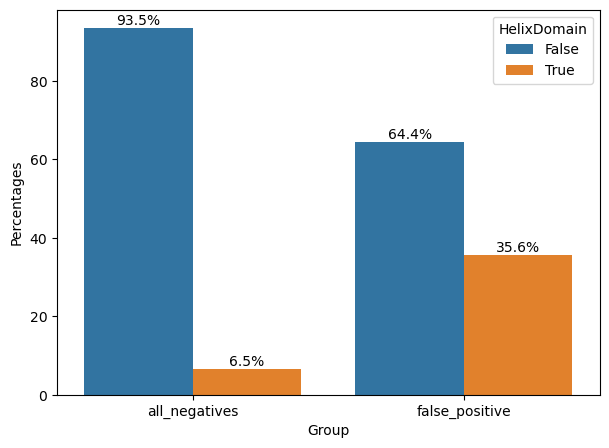

In [11]:
# create the subset with all negatives (fp+tn) and a version with only the fp

all_negatives=benchmark.query("Class=='Negative'").copy()
all_negatives['Group']="all_negatives" #change this to change the label on the x-axis
false_positive=benchmark.query("Prediction=='FP'").copy()
false_positive['Group']="false_positive" #change this to change the label on the x-axis
counts_group=pd.concat([false_positive,all_negatives], ignore_index=True)

# make counts in function of group and helix domain presence
counts = (
    counts_group
    .groupby(["Group", "HelixDomain"])
    .size()
    .rename("n")
    .reset_index()
)
# compute percentage within fp group and total negatives relative to its own size
counts["percent"] = counts.groupby("Group")["n"].transform(lambda s: ( s / s.sum())*100)

# make the plot
plt.figure(figsize=(7,5))
ax = sns.barplot(data=counts, x="Group", y="percent", hue="HelixDomain")
ax.set_ylabel("Percentages")
ax.set_xlabel("Group")
ax.legend(title="HelixDomain")
for c in ax.containers:
    ax.bar_label(c, fmt="%.1f%%")
plt.show()

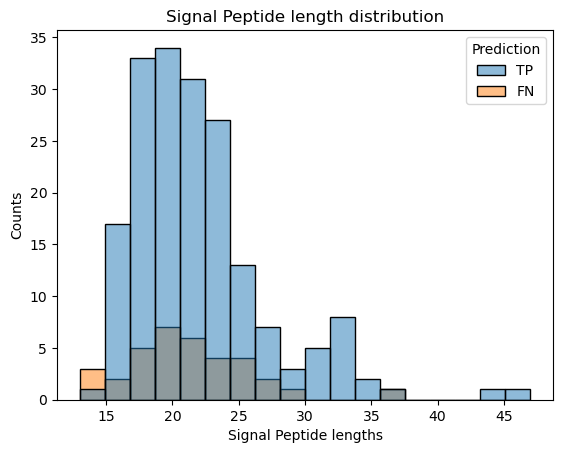

In [12]:
#signal peptide length distribution histogram

length_df = benchmark.query("Class == 'Positive'").copy()
length_df["sp_length"] = benchmark["SPEnd"] - benchmark["SPStart"]

sns.histplot(
    data=length_df,
    x="sp_length",
    hue="Prediction",
)

plt.title("Signal Peptide length distribution")
plt.ylabel("Counts")
plt.xlabel("Signal Peptide lengths")
plt.show()

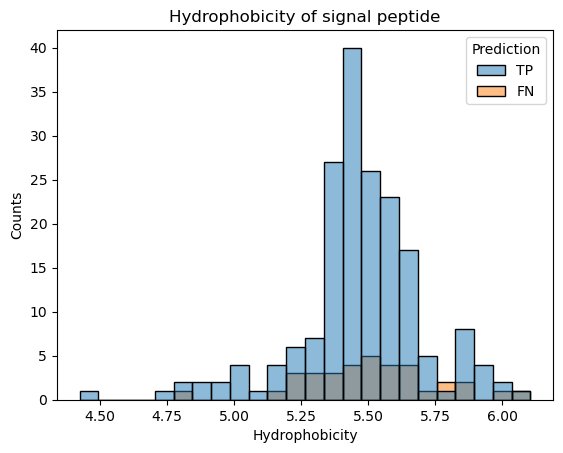

In [13]:
#hydrophobicity distribution

hydro_df = benchmark.query("Class == 'Positive'").copy()

hydro_df["hydrophobicity"] = hydro_df.apply(
    lambda row: get_scale_features(row["Sequence"], "mi", int(row["SPEnd"] - row["SPStart"]) , "mean"),
    axis=1
)

sns.histplot(
    data=hydro_df,
    x="hydrophobicity",
    hue="Prediction",
    
)

plt.title("Hydrophobicity of signal peptide")
plt.ylabel("Counts")
plt.xlabel("Hydrophobicity")
plt.show()

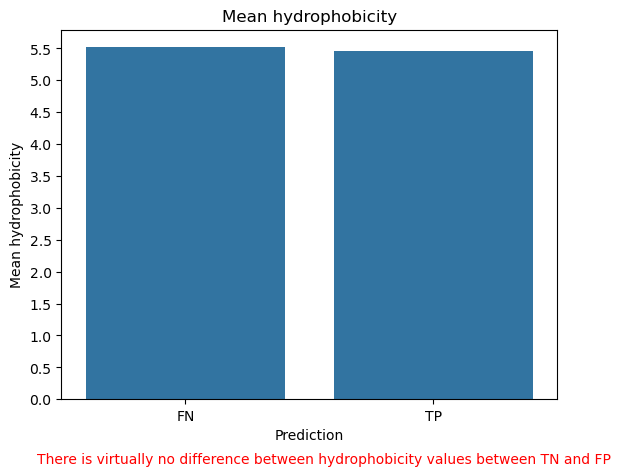

Prediction
FN    5.518082
TP    5.464034
Name: hydrophobicity, dtype: float64


In [14]:
# mean hydrophobicity percentage
import seaborn as sns
import matplotlib.pyplot as plt

hydro_means = hydro_df.groupby('Prediction')['hydrophobicity'].mean()

sns.barplot(x=hydro_means.index, y=hydro_means.values)

y_ticks = [i/10 for i in range(0, 60, 5)]
plt.ylabel("Mean hydrophobicity")  
plt.yticks(y_ticks)
plt.title("Mean hydrophobicity")
plt.text(-0.6, -1, "There is virtually no difference between hydrophobicity values between TN and FP", color='red', fontsize=10)
plt.show()
print(hydro_means)

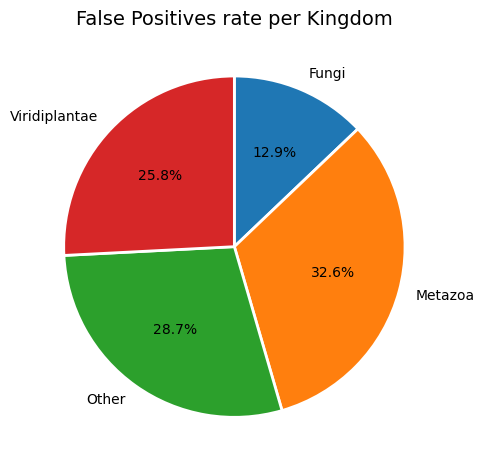

In [15]:
#pie plot with false positive for kingdom classification
false_positives=benchmark.query("Prediction=='FP'")
counts_falsepositive = (
    false_positives
    .groupby(["Kingdom", "Prediction"])
    .size()
    .rename("n")
    .reset_index()
)

counts_falsepositive["total"]=counts_falsepositive["Kingdom"].map(benchmark.query("Class=='Negative'").groupby(["Kingdom"]).size())
counts_falsepositive["percent"] = counts_falsepositive.groupby("Kingdom")["n"].transform(lambda s: ( s / counts_falsepositive["total"])*100)
fig, ax = plt.subplots()
ax.pie(
    counts_falsepositive["percent"],
    labels=counts_falsepositive["Kingdom"],
    autopct="%.1f%%",
    startangle=90,             # parte dall’alto
    counterclock=False,        # orientamento orario
    wedgeprops={"linewidth": 2, "edgecolor": "white"}
)
ax.set_title("False Positives rate per Kingdom", fontsize=14)
ax.set_aspect("equal")         # mantiene la forma circolare perfetta
plt.tight_layout()
plt.show()

In [16]:
#compute the fpr on the entire dataset
fpr_svm=len(false_positives)/len(benchmark.query("Class=='Negative'"))
fpr_helix_svm=len(false_positive.query("HelixDomain==True"))/len(benchmark.query("Class=='Negative' and HelixDomain==True"))
print("FPR SVM:",fpr_svm)
print("FPR SVM only on transmembrane proteins:", fpr_helix_svm)

FPR SVM: 0.02518186905428092
FPR SVM only on transmembrane proteins: 0.13675213675213677


In [17]:
fpr_von=int(confusion_df['Positive']['Negative'])/(int((confusion_df['Negative']['Positive']))+int(confusion_df['Negative']['Negative']))
print("FPR Von Heijne:",fpr_von)
# fpr_helix_von= non so come fare a selezionare le negative delle eliche

FPR Von Heijne: 0.04431818181818182
